## Table of Contents
* [1. improve segmentation](#1.-improve-segmentation)
	* [1.1 quantize pixels](#1.1-quantize-pixels)
	* [1.2 waterfall](#1.2-waterfall)
	* [1.3 direct from clusters](#1.3-direct-from-clusters)
	* [1.4 hybrid method](#1.4-hybrid-method)
	* [1.5 compare methods](#1.5-compare-methods)
	* [1.6 exp on single](#1.6-exp-on-single)
	* [1.7 labelme annotation](#1.7-labelme-annotation)
* [2. hide](#2.-hide)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
# %base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this
from anigen_tools.trajectory_viz import filter_chars, filter_description
from anigen_tools.trajectory_viz import avg_video_appearance
from anigen_tools.trajectory_viz import draw_trajectory_set
from anigen_tools.trajectory_viz import vid_filter

In [2]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

# plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [3]:
dataset = unpickle_this('../build_dataset/pickled_data/complete_dataset_3_3.pkl') 

In [4]:
with open('../build_dataset/dataset/dataset_v3p5.json') as f:
    dataset_3p5 = json.load(f)

In [5]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# 1. improve segmentation

## 1.1 quantize pixels

In [7]:
test_frames = dataset.data[2020].display_keyframes()

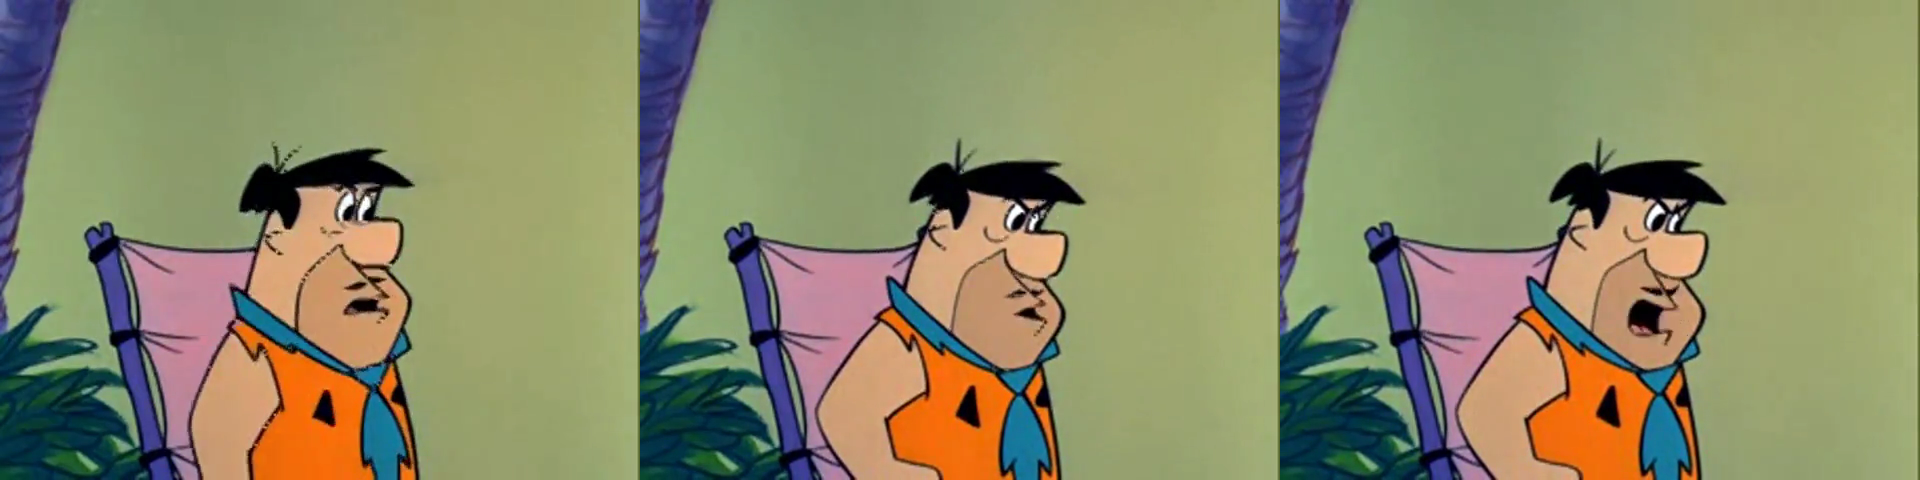

In [8]:
test_frames

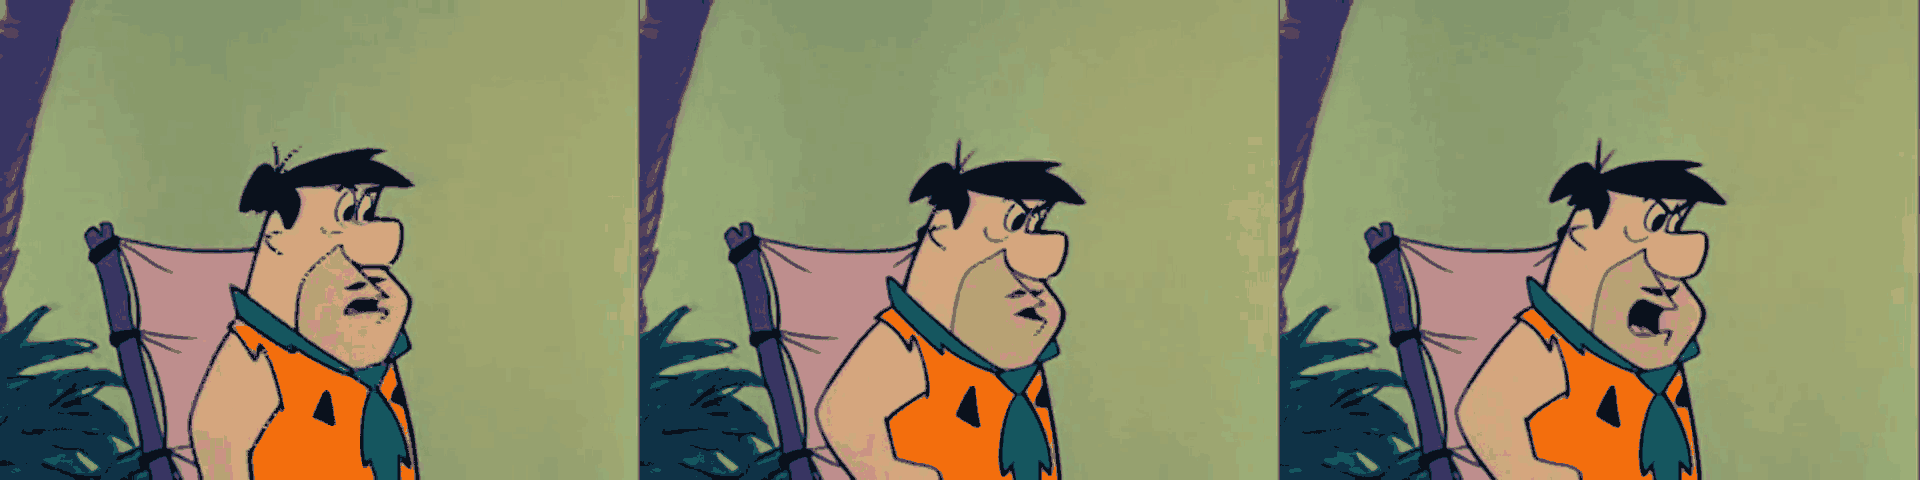

In [9]:
simplified = test_frames.convert('P', palette=pil.ADAPTIVE, colors=30)
simplified

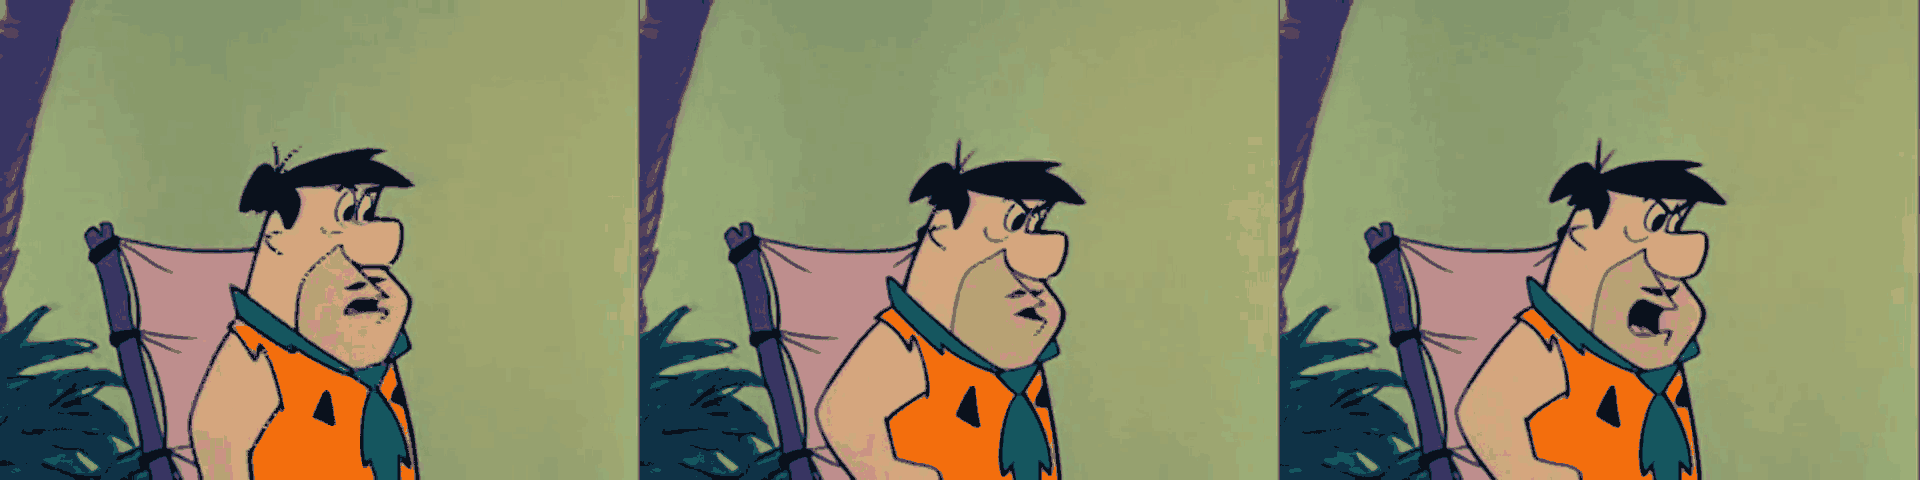

In [10]:
test_frames.quantize(colors=30, method=0)

In [20]:
frame_arr_dir = '/Users/schwenk/wrk/animation_gan/dataset/v3p0/trajectories/frame_arr_data/'

In [21]:
from sklearn.cluster import KMeans

In [22]:
def quant_img_kmeans_with_comp(image, n_clusters):
    simple_quant = pil.fromarray(image).quantize(colors=n_clusters, method=0)
    simple_convert = pil.fromarray(image).convert('P', palette=pil.ADAPTIVE, colors=n_clusters)
    h, w = image.shape[:2]
    image = cv2.cvtColor(test_128_img, cv2.COLOR_BGR2LAB)

    image = image.reshape((image.shape[0] * image.shape[1], 3))

    clt = KMeans(n_clusters = n_clusters)
    labels = clt.fit_predict(image)
    quantized_img = clt.cluster_centers_.astype("uint8")[labels]
    quantized_img = quantized_img.reshape((h, w, 3))
    image = image.reshape((h, w, 3))
    quantized_img = cv2.cvtColor(quantized_img, cv2.COLOR_LAB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    simple_conversions = [np.array(img.convert('RGB')) for img in [simple_quant, simple_convert]]
    return pil.fromarray(np.hstack([image, quantized_img] + simple_conversions))

In [23]:
random_sample = random.sample(dataset.data, 14)

In [24]:
for vid_id in tqdm(random_sample):
    segm_problem_video = vid_id.gid()
    test_arr_img = frame_arr_dir +segm_problem_video + '.npy'
    test_128_img = np.load(test_arr_img)[0]
    nc_quant_comps = [quant_img_kmeans_with_comp(test_128_img, nc) for nc in range(5, 55, 5)]
    img_comp_grid = pil.fromarray(np.vstack(nc_quant_comps))
    img_comp_grid.save('quant_comps/' + segm_problem_video + '.png')

  0%|          | 0/14 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'quant_comps/s_03_e_24_shot_016884_016958.png'

In [ ]:
from anigen_tools.segmentation import draw_video_segmentations
from anigen_tools.segmentation import segment_all_video_entities
from anigen_tools.segmentation import segment_from_quant_img

In [ ]:
def quant_img_kmeans(image, clt, label_only=False):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    labels = clt.fit_predict(image)
    if label_only:
        return labels.reshape((128, 128))
    quantized_img = clt.cluster_centers_.astype('uint8')[labels]
    quantized_img = quantized_img.reshape((128, 128, 3))
    quantized_img = cv2.cvtColor(quantized_img, cv2.COLOR_LAB2BGR)
    return quantized_img

In [178]:
segm_problem_video = 's_01_e_03_shot_023155_023229'

test_vid = get_vid(segm_problem_video)
test_arr_img = np.load(frame_arr_dir +segm_problem_video + '.npy')

In [266]:
qat = quant_img_kmeans(test_arr_img[0], clt)

In [283]:
from tqdm import tqdm_notebook

In [295]:
for nc in tqdm_notebook([5, 15, 30]):
    clt = KMeans(n_clusters = nc)
    for vid_id in tqdm_notebook(random_sample[:5]):
        segm_problem_video = vid_id.gid()
        test_arr_file = frame_arr_dir + segm_problem_video + '.npy'
        test_arr_img = np.load(test_arr_file)
        quant_img = np.array([quant_img_kmeans(frame, clt) for frame in tqdm_notebook(test_arr_img)])
        np.save('quantized_images/' + segm_problem_video + '_clust_' + str(nc) + '.npy', quant_img)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

HBox(children=(IntProgress(value=0, max=75), HTML(value='')))

In [ ]:
clt = KMeans(n_clusters = nc)

In [554]:
# quantized_frames = np.array([quant_img_kmeans(frame, clt) for frame in tqdm(test_arr_img)])

In [247]:
segment_from_quant_img(test_vid, quantized_frames)

In [251]:
draw_video_segmentations(test_vid, quantized_frames)

## 1.2 waterfall

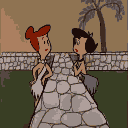

In [332]:
pil.fromarray(quantized_frames[0])

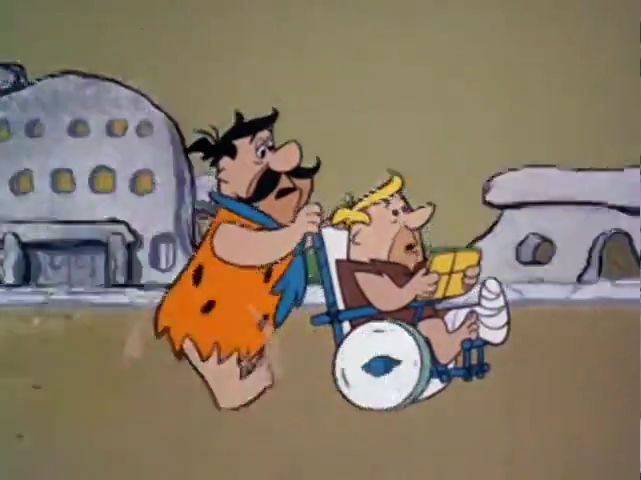

In [318]:
pil.fromarray(test_img)

In [352]:
clt = KMeans(n_clusters = 15)

orig_frames = quant_img_kmeans(test_arr_img[40], clt)

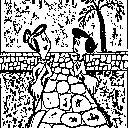

In [525]:
pil.fromarray(thresh)

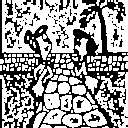

In [526]:
pil.fromarray(opening)

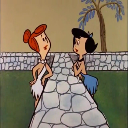

In [547]:
pil.fromarray(test_arr_img[40])

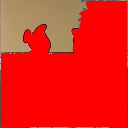

In [548]:
test_img = deepcopy(test_arr_img[40])
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 3)

# test_img = np.array(test_vid.display_keyframes())[:, :641, :]
# ret, thresh = cv2.threshold(gray, 0, 255 , cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# thresh = cv2.adaptiveThreshold(test_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,\
#             cv2.THRESH_BINARY,11,2)
# th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel, iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(test_img, markers)

test_img[markers == 1] = [255,0,0]
pil.fromarray(test_img)

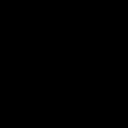

In [550]:
pil.fromarray(markers)

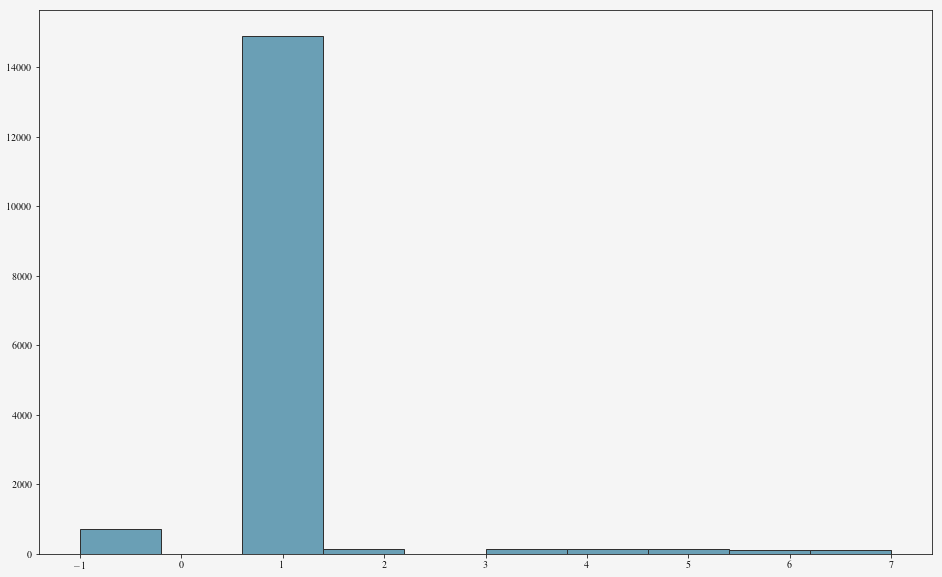

In [539]:
_ = pd.Series(markers.ravel()).hist()

## 1.3 direct from clusters

In [603]:
from pylab import imshow, show, get_cmap

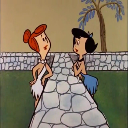

In [557]:
pil.fromarray(orig_frame)

In [1187]:
# test_vid.display_bounding_boxes()

In [864]:
clt = KMeans(n_clusters = 5)
img_clusters = quant_img_kmeans(orig_frame, clt, True)

In [636]:
from anigen_tools.segmentation import scale_box

In [1186]:
# _ = imshow(img_clusters, cmap=get_cmap("viridis"), interpolation='nearest')

In [1189]:
char_seg = create_entity_segment(test_char)

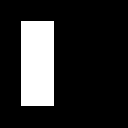

In [1190]:
pil.fromarray(convert_to_rgb(char_seg))

In [865]:
cluster_1 = img_clusters == 2
cluster_1 = cluster_1.astype(np.uint8)
cluster_1_disp = convert_to_rgb(cluster_1)

In [1191]:
# n_cc, markers = cv2.connectedComponents(cluster_1)

In [1192]:
# pil.fromarray(cluster_1_disp)

In [787]:
from  ai2.vision.utils.cv import area_intersect_over_union as aiou

In [911]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import data, io, segmentation, color
from skimage.future import graph

In [880]:
n_segments = 100

In [ ]:
clt = KMeans(n_clusters = 15)
img_clusters = quant_img_kmeans(orig_frame, clt, False)

## 1.4 hybrid method

In [44]:
from anigen_tools.hybrid_segmentation import segment_entity
from anigen_tools.hybrid_segmentation import gen_single_segmentation
from anigen_tools.hybrid_segmentation import segment_video
from anigen_tools.segmentation import draw_video_segmentations

In [7]:
from skimage.segmentation import mark_boundaries
from skimage import color

from anigen_tools.hybrid_segmentation import create_bbox_segment
from anigen_tools.hybrid_segmentation import partition_image
from anigen_tools.hybrid_segmentation import rough_segment
from anigen_tools.hybrid_segmentation import grabcut_from_rough_mask
from anigen_tools.hybrid_segmentation import scale_box
from anigen_tools.hybrid_segmentation import compute_iou

In [8]:
from copy import deepcopy

In [9]:
def show_images_horizontally(images, ent_name):
    fig = plt.figure()
    for i, image in enumerate(images):
        a=fig.add_subplot(1,len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.savefig('./segmentation_comps/' + ent_name, bbox_inches='tight')

In [17]:
frame_arr_dir = '/Users/schwenk/wrk/animation_gan/dataset/v2p5/trajectories/frame_arr_data/'

In [11]:
def apply_mask(img, mask):
    return pil.fromarray(img * np.tile(np.expand_dims(mask, 2), [1, 1, 3]))

def convert_to_rgb(bin_img):
    return pil.fromarray(np.tile(np.expand_dims(bin_img * 255, 2), [1, 1, 3]))

In [52]:
# segm_problem_video = 's_01_e_03_shot_023155_023229'
# test_vid = get_vid(segm_problem_video)
# test_vid = random.choice(datset)
test_arr_img = np.load(frame_arr_dir +test_vid.gid() + '.npy')
test_frame = test_arr_img[40]
test_char = test_vid.data()['characters'][0]
# test_char = test_vid.data()['objects'][0]

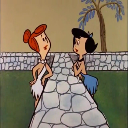

In [53]:
pil.fromarray(test_frame)

In [54]:
test_char_segm = gen_single_segmentation(test_vid, test_char, 100)
# convert_to_rgb(test_char_segm)

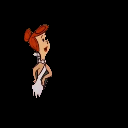

In [55]:
test_char_segm

In [57]:
# pil.fromarray(test_frame * np.tile(np.expand_dims(rough_ent, 2), [1, 1, 3]))

In [337]:
# test_vid.display_bounding_boxes()

In [14]:
segm_problem_video = 's_01_e_03_shot_023155_023229'
test_vid = get_vid(segm_problem_video)

In [58]:
# segment_video(test_vid, 1000)
# draw_video_segmentations(test_vid)

# test_seg = np.load('/Users/schwenk/wrk/animation_gan/analyze_ds/trajectories/segmentation/s_01_e_03_shot_023155_023229_char_0_segm.npy.npz')['arr_0']
# img_seq = [pil.fromarray(convert_to_rgb(test_seg[n])) for n in range(50, 60)]
# show_images_horizontally(img_seq)

## 1.5 compare methods

In [35]:
tanmay_res_dir_pow_2 = './tanmay_segmentations/scratch2_prob_unary_pow_2/'
tanmay_res_dir_pow_4 = './tanmay_segmentations/scratch2_prob_unary_pow_4/'
tanmay_res_dir_log_pow_2 = './tanmay_segmentations/scratch_prob_log_unary_pow_2//'
result_dirs = [tanmay_res_dir_pow_2, tanmay_res_dir_pow_4, tanmay_res_dir_log_pow_2]

In [13]:
seg_files_1 = os.listdir(tanmay_res_dir_pow_2)
seg_files_1 = [f for f in seg_files_1 if 'seg' in f]

In [14]:
ents_in_sample = [f.split('_seg')[0] for f in seg_files_1]

In [15]:
ents_in_sample[:1]

['s_01_e_27_shot_013211_013285_drum_0_8']

In [16]:
vids_in_sample = set(['_'.join(ent.split('_', maxsplit=7)[:7]) for ent in ents_in_sample])

In [162]:
for ent in ents_in_sample:
    try: 
        make_seg_comp(ent)
    except:
        pass 

In [32]:
def gen_single_segmentation(video, ent, n_segments=500, frame_n=30):
    test_arr_img = np.load(frame_arr_dir + video.gid() + '.npy')
    anim_frame = test_arr_img[frame_n]
    ent_rects = np.load('./trajectories/tracking/' + ent.gid() + '.npy')
    ent_rects = ent_rects[frame_n]
    img = deepcopy(anim_frame)
    scaled_ent_box = scale_box(ent_rects)
    ent_bbox_mask = create_bbox_segment(scaled_ent_box)
    img_regions = partition_image(img, n_segments)
    rough_ent = rough_segment(img_regions, ent_bbox_mask, 0.5)
    ent_segmentation = grabcut_from_rough_mask(rough_ent, img)
    return ent_segmentation, pil.fromarray(anim_frame * np.tile(np.expand_dims(ent_segmentation, 2), [1, 1, 3]))

In [33]:
def make_seg_comp(ent_id):
    vid_id = '_'.join(ent_id.split('_', maxsplit=7)[:7])
    video = get_vid(vid_id)
    entity = [ent for ent in video.data()['characters'] + video.data()['objects'] if ent.gid() == ent_id][0]
    dustins_seg =  gen_single_segmentation(video, entity, 500)
    tanmay_ent_img_seq = [pil.open(rd + ent_id + '_seg.png') for rd in result_dirs]
    _ = show_images_horizontally([dustins_seg] + tanmay_ent_img_seq, ent_id)

In [34]:
segm_problem_video = 's_01_e_03_shot_023155_023229'
test_vid = get_vid(segm_problem_video)
test_char = test_vid.data()['characters'][0]
seg_mask, single_seg = gen_single_segmentation(test_vid, test_char) 

NameError: name 'frame_arr_dir' is not defined

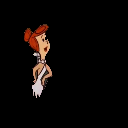

In [173]:
single_seg

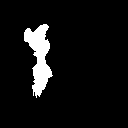

In [176]:
pil.fromarray(convert_to_rgb(seg_mask))

In [166]:
test_vid.get_key_frame_images()[0].save('test_frame.png')

with open('./test_frame.json') as f:
    labelme_anno = json.load(f)

wilma_poly = labelme_anno['shapes'][0]['points']

polyr, polyc = np.array(list(zip(*wilma_poly)), dtype=np.uint8)

from skimage.draw import polygon

labelme_mask = np.zeros_like(test_vid.get_key_frame_images()[0])

rr, cc = polygon(polyr, polyc)
labelme_mask[rr, cc] = 1

In [163]:
# gen_single_segmentation(test_vid, test_char, 500, 30)

## 1.6 exp on single

In [59]:
t_frame_n = 54

test_arr_img = np.load(frame_arr_dir +test_vid.gid() + '.npy')
test_frame = test_arr_img[t_frame_n]

test_char = test_vid.data()['characters'][0]
test_rects = np.load('./trajectories/tracking/' +test_char.gid() + '.npy')
test_rect = test_rects[t_frame_n]

In [60]:
# other_ents = [oe for oe in test_vid.data()['characters'] + test_vid.data()['objects'] if oe.gid() != test_char.gid()]
# other_rects = [np.load(os.path.join('./trajectories/tracking/', oe.gid() + '.npy'))[t_frame_n] for oe in other_ents]

In [61]:
n_segments = 500
img = deepcopy(test_frame)
scaled_ent_box = scale_box(test_rect)

ent_bbox_mask = create_bbox_segment(scaled_ent_box)
img_regions = partition_image(img, n_segments)
rough_ent = rough_segment(img_regions, ent_bbox_mask, 0.9)

In [63]:
# ent_mask = rough_ent
# mask = np.where(ent_mask == 1, cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
# mask = mask * (arsum ==0)

In [64]:
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
cv2.grabCut(img, mask, None, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_MASK)
ref_mask = np.where((mask == 3), 1, 0).astype('uint8')

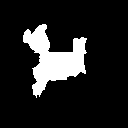

In [67]:
convert_to_rgb(ref_mask)

In [70]:
ent_segmentation = grabcut_from_rough_mask(rough_ent, img)
img_seq = [apply_mask(test_frame, rough_ent), apply_mask(test_frame, ent_segmentation)]
# show_images_horizontally(img_seq)

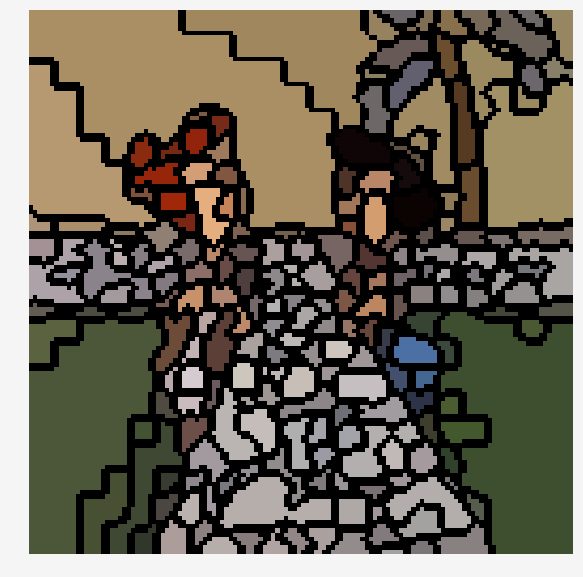

In [741]:
out = color.label2rgb(img_regions, img, kind='avg')
out = mark_boundaries(out, img_regions, (0, 0, 0))

_ = plt.imshow(out)
_ = plt.axis("off")

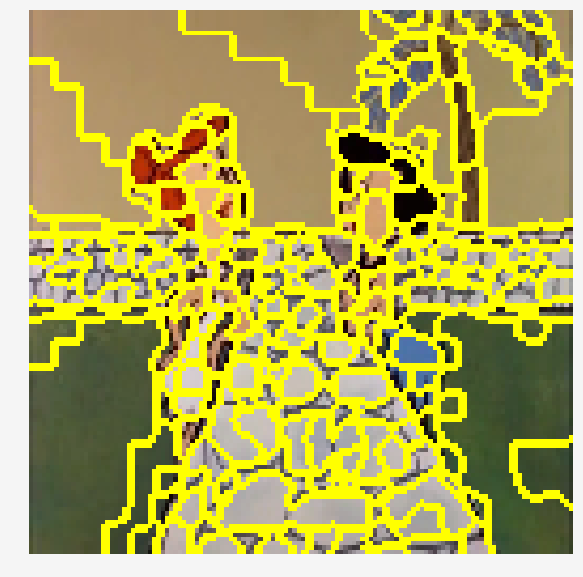

In [695]:
_ = plt.imshow(mark_boundaries(test_frame, img_regions))
_ = plt.axis("off")

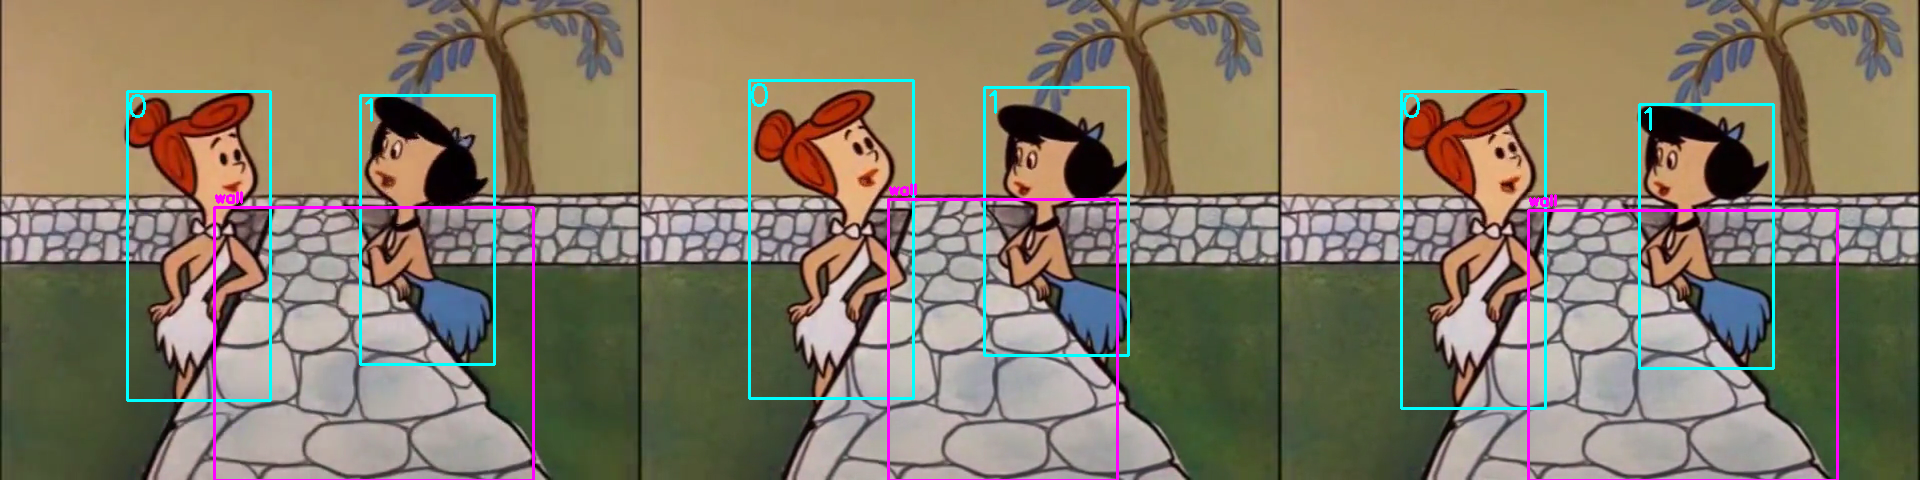

In [495]:
test_vid.display_bounding_boxes()

In [ ]:
_ = plt.imshow(mark_boundaries(orig_frame, segments))
_ = plt.axis("off")

## 1.7 labelme annotation

In [41]:
import labelme
from copy import deepcopy

In [399]:
from anigen_tools.hybrid_segmentation import compute_iou

In [2]:
sample_anno = 's_01_e_08_shot_003729_003803_suit_1_6_bb.png,(482,306),(551,290),(551,394),(541,454),(450,454),(435,369)'

In [37]:
ent_id, coords = sample_anno.split(',', maxsplit=1)

In [56]:
vertices_arr = np.array([c.split(')')[0].split(',') for c in coords.split('(') if c], dtype=np.float32)

In [202]:
test_vid = get_vid('s_01_e_08_shot_003729_003803')

In [197]:
test_img = test_vid.get_key_frame_images()[0]
# test_img.save('test_frame.png')

# with open('./test_frame.json') as f:
#     labelme_anno = json.load(f)

In [198]:
test_char = test_vid.data()['objects'][1]

In [73]:
segm_problem_video = 's_01_e_03_shot_023155_023229'
test_vid = get_vid(segm_problem_video)

test_char = test_vid.data()['objects'][0]
seg_mask = gen_single_segmentation(test_vid, test_char, n_segments=500)

In [76]:
b2_df = pd.read_pickle('../turk_annotation_task/segm_anno/poly_segm_res.pkl')

In [77]:
b2_df.head()

,a_id,ent_id,h_id,poly,v_id,worker_id,n_points
0,34S9DKFK74P1MYQOCV2G1L7NCSWNYW,s_01_e_08_shot_001903_001977_char_0,3UY4PIS8QSL198HRA4Q5YE1S8U01NQ,"((164, 201), (164, 164), (168, 144), (136, 140...",s_01_e_08_shot_001903_001977,AVNETQM99TKA7,55
1,3FDJT1UU7582C4V14G53YWSQNSNK58,s_04_e_17_shot_030776_030850_eye shadow_0_16,3OZ4VAIBEYFLCU642KI2CVRROE2JVT,"((327, 206), (318, 202), (311, 205), (311, 214...",s_04_e_17_shot_030776_030850,A2KXARDIOGJL8T,10
2,3GGAI1SQEWYI1D4J425RRFQ43D3MCJ,s_01_e_03_shot_023155_023229_char_0,3V8JSVE8YZQU58FHTUUVMEIT1N8EYC,"((180, 402), (212, 349), (221, 332), (218, 322...",s_01_e_03_shot_023155_023229,A24F42H3K58D8A,45
3,3CFJTT4SXUQQTDJWS6ZOJ0R9LTSI76,s_01_e_03_shot_019734_019808_char_0,31JUPBOORO4TW8YRXCJ50WKBH56L8S,"((239, 477), (518, 475), (519, 458), (534, 434...",s_01_e_03_shot_019734_019808,A24F42H3K58D8A,31
4,3D8YOU6S9FKCY40R3DJAWPFOKDVU6R,s_05_e_22_shot_017017_017091_char_0,3T2HW4QDUW7079NVPRWKX9PZ72A9CP,"((290, 100), (298, 118), (305, 109), (308, 101...",s_05_e_22_shot_017017_017091,AFSB8WBSUU2B4,76


In [151]:
sorted_df[sorted_df['worker_id'] == 'ALGVMVD50EC04']

,a_id,ent_id,h_id,poly,v_id,worker_id,n_points
45,32UTUBMZ7HWIHV6M4UAN3R3ZCLFVB2,s_03_e_25_shot_042570_042644_char_0,3EKZL9T8Y9MTMF5EN3KCAQNNQFICHI,"((218, 52), (474, 51), (475, 476), (222, 476))",s_03_e_25_shot_042570_042644,ALGVMVD50EC04,4
188,3L0KT67Y8FGY2BITKRJ20FHTYQ3SY9,s_03_e_17_shot_041699_041773_costume_0_5,3PMR2DOWOP1EBI84TMDL2V89TTA45G,"((477, 318), (603, 310), (592, 468), (452, 473))",s_03_e_17_shot_041699_041773,ALGVMVD50EC04,4
109,3L6L49WXW1XHY26YJOINRF3UQ6X543,"s_05_e_09_shot_040095_040169_bed,_0_5",3W5PY7V3UQ72GO197V5MJUVL6V3YJG,"((8, 240), (135, 232), (186, 279), (226, 231),...",s_05_e_09_shot_040095_040169,ALGVMVD50EC04,10
53,3UJ1CZ6IZIP00N899PE5PIJ04M05SA,s_04_e_26_shot_016234_016308_hat_1_11,3538U0YQ1GULVJIPZKLBE27G4NSF3P,"((158, 233), (137, 238), (147, 215), (143, 187...",s_04_e_26_shot_016234_016308,ALGVMVD50EC04,12
214,3ZAK8W07I5EHKTEC1O3TNO5X8BA0U0,s_04_e_18_shot_011352_011426_desk_0_11,3M67TQBQQIOCEUQX5D0TREZB7ZP9AN,"((138, 368), (96, 373), (95, 403), (115, 427),...",s_04_e_18_shot_011352_011426,ALGVMVD50EC04,12
58,3VW04L3ZLU6HYNEI953NG9RCBZBXXG,s_04_e_08_shot_004004_004078_char_0,3421H3BM9BHNFNT1ZJD6KD2UXMJ9J3,"((275, 101), (239, 130), (270, 139), (270, 185...",s_04_e_08_shot_004004_004078,ALGVMVD50EC04,20
73,345LHZDEDYSD1LD9KBLCPM34BNU3UY,s_02_e_17_shot_014483_014557_chair_1_18,335VBRURDK0F4779LI2FNXP2SEN9EI,"((574, 217), (587, 216), (583, 241), (598, 243...",s_02_e_17_shot_014483_014557,ALGVMVD50EC04,22
147,3WYP994K18RTFDKWDEGZZAL1G16Y6T,s_02_e_30_shot_033348_033422_char_0,3WGCNLZJKG8SNWQELAC229PYUQY1D8,"((518, 299), (556, 476), (387, 474), (361, 444...",s_02_e_30_shot_033348_033422,ALGVMVD50EC04,26
172,3D3VGR7TA1FLLTLSGHQ7KBGK4OQ3RU,s_06_e_07_shot_042740_042814_char_0,3VQTAXTYN4LFHWJS92VGIL6V22KBUB,"((258, 257), (265, 244), (271, 240), (285, 200...",s_06_e_07_shot_042740_042814,ALGVMVD50EC04,35


In [94]:
sorted_df = b2_df.sort_values('n_points')

In [174]:
sorted_df.iloc[0:10]

,a_id,ent_id,h_id,poly,v_id,worker_id,n_points
57,3OS4RQUCRAFTLYKW4F5JL50DPSSFB2,s_01_e_25_shot_017596_017670_script_0_9,3W1K7D6QSCHW3VD2FPUOZDLA4KZBZ0,"(304, 284)",s_01_e_25_shot_017596_017670,A1LZWU72K42V92,2
20,39RP059MEITZR8CDQ29WGVKMMT4MBG,s_02_e_17_shot_014483_014557_elbow_1_12,3IH9TRB0FCZ9V760DODDT65BMV61IA,"((563, 225), (576, 225), (564, 251))",s_02_e_17_shot_014483_014557,A1Z37HK53J8S87,3
45,32UTUBMZ7HWIHV6M4UAN3R3ZCLFVB2,s_03_e_25_shot_042570_042644_char_0,3EKZL9T8Y9MTMF5EN3KCAQNNQFICHI,"((218, 52), (474, 51), (475, 476), (222, 476))",s_03_e_25_shot_042570_042644,ALGVMVD50EC04,4
96,3KGTPGBS6YLOG3HQGB776CYC48TU2A,s_03_e_18_shot_025408_025482_char_0,3GV1I4SEOAP6SUF34XM7GIOKBAG6LR,"((388, 53), (551, 55), (553, 406), (390, 406))",s_03_e_18_shot_025408_025482,A36KTM4CGRWV70,4
180,3CPLWGV3MPZMLXIG4JA024EW3JB9NT,s_02_e_18_shot_023725_023799_char_1,32204AGAACC63RLJPPGV0H82O7AHGX,"((152, 142), (151, 364), (347, 364), (347, 141))",s_02_e_18_shot_023725_023799,A35ON5YN1HY1H6,4
188,3L0KT67Y8FGY2BITKRJ20FHTYQ3SY9,s_03_e_17_shot_041699_041773_costume_0_5,3PMR2DOWOP1EBI84TMDL2V89TTA45G,"((477, 318), (603, 310), (592, 468), (452, 473))",s_03_e_17_shot_041699_041773,ALGVMVD50EC04,4
192,351SEKWQS1HS65AX4Y02BL8MODFMDJ,s_02_e_01_shot_030444_030518_cap_2_9,3DQYSJDTYMB553P7OY8T30BKZHEEX6,"((260, 19), (260, 38), (276, 39), (278, 18))",s_02_e_01_shot_030444_030518,A24F42H3K58D8A,4
194,37U1UTWH9WM7MQRYSYL3BSOVKAI8RR,s_04_e_22_shot_021109_021183_roof_0_16,30ZKOOGW2X6UPPN210L0C8HS9N11A6,"((195, 7), (481, 138), (638, 152), (638, 5))",s_04_e_22_shot_021109_021183,AM86ZA21GS08F,4
111,3G5W44VEU8I0S1KLLCOU2TJFC00KGM,s_02_e_03_shot_036993_037067_shirt_1_5,30OITAWPBR3ROHYBBJAL80MFKUFH96,"((220, 278), (408, 276), (409, 477), (221, 478))",s_02_e_03_shot_036993_037067,A36KTM4CGRWV70,4
112,3GS6S824SRXXXTVOXUKSGOM70JVNWT,s_03_e_22_shot_029491_029565_char_0,33BFF6QPI2BN654KP9VBIQTGZQI3WB,"((180, 112), (297, 111), (298, 478), (120, 477...",s_03_e_22_shot_029491_029565,A1Z0KYB5YLUO0A,5


s_03_e_16_shot_034648_034722_char_0
3SKRO2GZ72R3OMUI3T3RV6F9BCI1K7


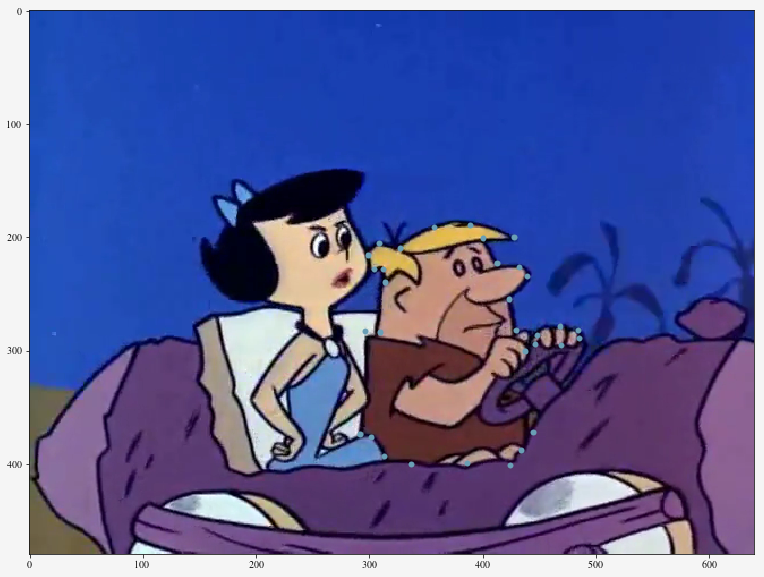

In [195]:
row_n = 16
test_vid = sorted_df['v_id'].iloc[row_n]
test_poly = sorted_df['poly'].iloc[row_n]
print(sorted_df['ent_id'].iloc[row_n])
print(sorted_df['a_id'].iloc[row_n])

test_img = get_vid(test_vid).get_key_frame_images()[1]

# ent_poly = np.array(labelme_anno['shapes'][1]['points'])
ent_poly = test_poly
anno_mask = labelme.utils.polygons_to_mask((480, 640), ent_poly).astype(np.uint8)
rescaled_anno_mask = np.array(pil.fromarray(anno_mask).resize((128, 128)))

compute_iou(rescaled_anno_mask, seg_mask)

plt.imshow(test_img)
ent_poly = np.array(ent_poly)
_ =plt.plot(ent_poly[:,0], ent_poly[:,1], 'o')
# plt.plot(wilma_poly[hull.vertices,0], wilma_poly[hull.vertices,1], 'r--', lw=2)

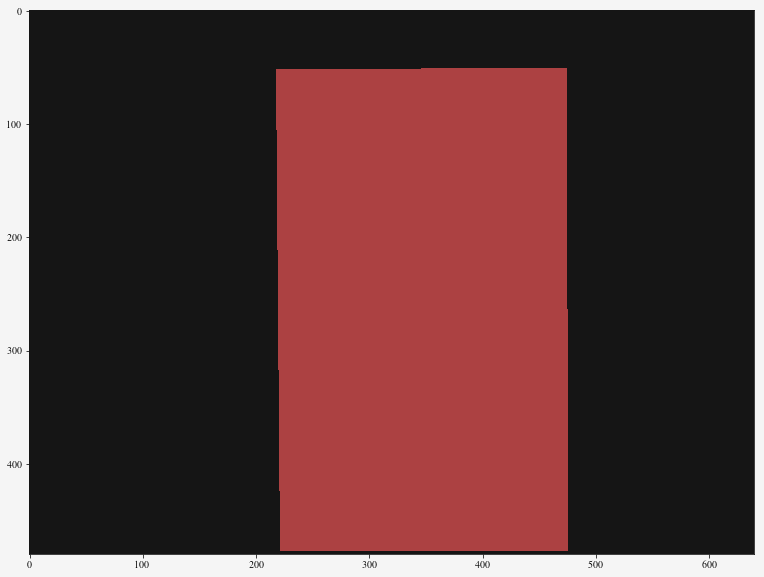

In [178]:
_ = plt.imshow(anno_mask)

In [74]:
# get_vid('s_01_e_03_shot_023155_023229')

# 2. hide

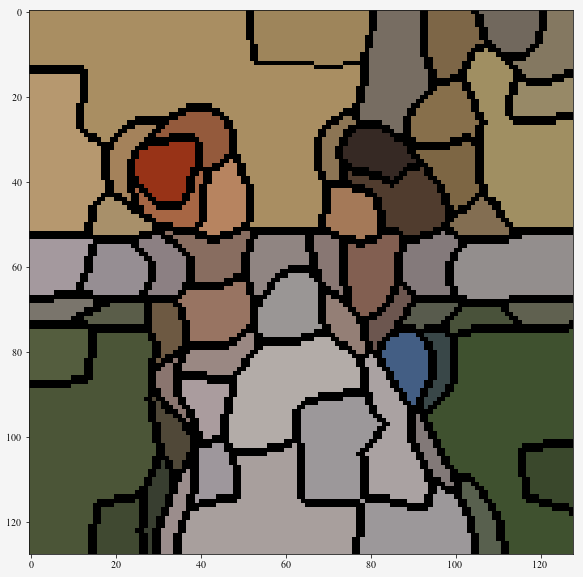

In [1180]:
_ = plt.imshow(out)

segments = slic(orig_frame, n_segments = 100, sigma = 5, multichannel=True, convert2lab=True, compactness=10)

_ = plt.imshow(mark_boundaries(orig_frame, segments))
_ = plt.axis("off")

In [ ]:
import skimage
from skimage import measure
regions = measure.regionprops(exp_segm, intensity_image=orig_frame)

In [1184]:
# print([r.area for r in regions])a
# print([r. for r in regions])

# mc = [orig_frame[:, :, i].mean() for i in range(orig_frame.shape[-1])]

# segments = slic(img_clusters, n_segments = n_segments, sigma = 5, multichannel=True, convert2lab=True, compactness=10)

# _ = plt.imshow(mark_boundaries(img_clusters, segments))
# _ = plt.axis("off")

In [ ]:
ent = test_ents[0]
ent_mask = np.load(os.path.join(data_dir, segmentation_dir, ent.gid() + '_segm.npy.npz'))['arr_0'].astype(np.uint64)
ent_mask2 = np.load(os.path.join(data_dir, segmentation_dir, test_ents[1].gid() + '_segm.npy.npz'))['arr_0'].astype(np.uint64)

In [1294]:
# def weight_mean_color(graph, src, dst, n):
#     diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
#     diff = np.linalg.norm(diff)
#     return {'weight': diff}


# def merge_mean_color(graph, src, dst):
#     graph.node[dst]['total color'] += graph.node[src]['total color']
#     graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
#     graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
#                                      graph.node[dst]['pixel count'])

# def create_entity_segment(ent, frame_size=(128, 128)):
#     segment = np.zeros(frame_size, dtype=np.uint8)
#     rect = scale_box(np.array(ent.rect())[1])
#     segment[rect[0]: rect[2], rect[1]: rect[3]] = 1
#     return segment.T


# def partition_image(img, n_segments):
#     superpixels = slic(img, n_segments, sigma = 5, multichannel=True, convert2lab=True, compactness=10)
#     ent_rag = graph.rag_mean_color(img, labels)

#     regions = graph.merge_hierarchical(superpixels, g, thresh=10, rag_copy=False,
#                                        in_place_merge=True,
#                                        merge_func=merge_mean_color,
#                                        weight_func=weight_mean_color)
# #     out = color.label2rgb(regions, img, kind='avg')
# #     out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
#     return regions


# def rough_segment(regions, bbox_mask, frame, inclusion_thresh=0.7):
#     wilma_reg_overlaps = []
#     for reg in np.unique(regions):
#         reg_mask = regions == reg
#         reg_mask = reg_mask.astype(np.uint8)
#         reg_iou = aiou(bbox_mask, reg_mask)[2]
#         wilma_reg_overlaps.append(reg_iou)
#     overlapping_regions = pd.Series(wilma_reg_overlaps).sort_values(ascending=False)
#     regions_to_include = overlapping_regions.index[overlapping_regions > inclusion_thresh]
#     ent_segment = np.isin(regions, regions_to_include).astype(np.uint8)
# #     masked_ent = frame * np.tile(np.expand_dims(ent_segment, 2), [1, 1, 3])
#     return ent_segment


# def grabcut_from_rough_mask(ent_mask, img):
#     mask = np.where(ent_mask == 1, cv2.GC_PR_FGD, 0).astype('uint8')
#     mask[ent_mask == 0] = cv2.GC_BGD
#     # mask[newmask == 255] = cv2.GC_FGD
#     bgdModel = np.zeros((1,65),np.float64)
#     fgdModel = np.zeros((1,65),np.float64)
# #     return mask
#     mask, bgdModel, fgdModel = cv2.grabCut(img, mask, None, bgdModel, fgdModel, 1 ,cv2.GC_INIT_WITH_MASK)
#     mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#     img = img * mask[:,:,np.newaxis]
#     return img


# def segment_entity(frame, entity, n_segments=100):
#     img = deepcopy(frame)
#     img_regions = partition_image(img, n_segments)
#     ent_bbox = create_entity_segment(entity)
#     rough_ent = rough_segment(img_regions, ent_bbox, img)
# #     return rough_ent
#     ent_segmentation = grabcut_from_rough_mask(rough_ent, img)
#     return ent_segmentation

In [ ]:
# from nltk.parse.corenlp import CoreNLPParser
# core_parser = CoreNLPParser(url='http://localhost:9000')    


# from anigen_tools.tracking import draw_video_tracking

# from anigen_tools.parsing import const_parse

# desc = 

# parsed_sent = const_parse(vd, core_parser)

# pickle_this(parsed_sent[0], 'sent_to_viz.pkl')

# import Tkinter as tk

# import Tkinter
# import ttk
# import Tkinter as tk


# from nltk.draw.tree import TreeView

# vd = 'Fred is in the playroom playing pool.  The middle aged man in red suit walks up to him with the chalk and starts a conversation.'

# tree_name = './' + 'demo_vid' + '_sent_' +'0' + '_parse_tree'
# TreeView(parsed_sent[0])._cframe.print_to_file(tree_name + '.ps')

# parsed_sent[0]

# draw_video_tracking(demo_vid)

# gb_ex =np.load('/Users/schwenk/wrk/animation_gan/build_dataset/trajectories/all_bg/s_01_e_08_shot_003729_003803_bg.npy.npz')['arr_0']

# pil.fromarray(gb_ex[40])